## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
##Importing required stats/DL/ML packages. E.g. Keras, scikit-learn, etc.

%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import scipy
import seaborn as sns
import sklearn.model_selection as skl
import tensorflow as tf

from glob import glob
from random import sample
from itertools import chain
from random import sample 
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Loading the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN


In [3]:
## Creating extra columns in table with binary indicators of certain diseases 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.head(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0


In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['Image_Path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Image_Path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000001_002.png


## Create your training and testing data:

In [ ]:
def create_splits():
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    

   
    return train_df, valid_df

In [5]:
train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])

In [6]:
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [7]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

In [8]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [9]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [10]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [11]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.5

In [ ]:
def check_for_image_in_train_valid(train_df, valid_df):
    
    
    train_df_image_unique = set(train_df['Image Index'].values)
    valid_df_image_unique = set(valid_df['Image Index'].values)
    
    
    image_in_both_sets = list(train_df_image_unique.intersection(valid_df_image_unique))

    
    if (len(image_in_both_sets)!=0):
        duplicate = True
    else:
        duplicate = False
    
    return duplicate

In [ ]:
check_for_image_in_train_valid(train_df, valid_df)

In [ ]:
def check_for_patient_in_train_valid(train_df, valid_df):
    
    
    train_df_patients_unique = set(train_df['Patient ID'].values)
    valid_df_patients_unique = set(valid_df['Patient ID'].values)
    
    
    patients_in_both_sets = list(train_df_patients_unique.intersection(valid_df_patients_unique))

    
    if (len(patients_in_both_sets)!=0):
        duplicate = True
    else:
        duplicate = False
    
    return duplicate

In [ ]:
check_for_patient_in_train_valid(train_df, valid_df)

# Now we can begin our model-building & training

#First suggestion: perform some image augmentation on your data

In [ ]:
#First, let's look at what our plan images look like

fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
plt.tight_layout()
imgs = all_xray_df['Image_Path']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='bone')
    ax.set_title(all_xray_df.iloc[ind]['Pneumonia'])
    ind=ind+1

In [ ]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
#IMG_SIZE = (320, 320)

In [12]:
def get_train_gen(train_df, image_dir, x_cols, y_cols, shuffle=True, batch_size=64, seed=1, target_w = 224, target_h = 224):
    print("getting train generator...") 
    # normalize images
    image_gen = ImageDataGenerator(rescale=1./255, 
                                         zoom_range=0.3, 
                                         vertical_flip=True,
                                         samplewise_center=True,
                                         samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    train_gen = image_gen.flow_from_dataframe(
            dataframe=train_df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode="raw",
            shuffle=shuffle,
            batch_size=batch_size,
            seed=seed,
            target_size=(target_w,target_h))
    
    return train_gen


In [13]:
def get_valid_gen(valid_df, train_df, image_dir, x_cols, y_cols, sample_size=64, batch_size=32, seed=1, target_w = 224, target_h = 224):
    print("getting valid generators...")

    # get data sample
    batch = train_gen.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_gen = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=True,
                                    featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_gen.fit(data_sample)

    # get test generator
    valid_gen = image_gen.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return valid_gen

In [14]:
train_gen = get_train_gen(train_df, None, 'Image_Path', 'Pneumonia')
valid_gen= get_valid_gen(valid_df, train_df, None, 'Image_Path', 'Pneumonia')

getting train generator...
Found 2290 validated image filenames.
getting valid generators...
Found 572 validated image filenames.


In [15]:
valX, valY = valid_gen.next()

In [16]:
valX

array([[[[ 4.7098301e-02,  4.7098301e-02,  4.7098301e-02],
         [ 4.7098301e-02,  4.7098301e-02,  4.7098301e-02],
         [ 6.2797837e-02,  6.2797837e-02,  6.2797837e-02],
         ...,
         [ 1.9624108e-02,  1.9624108e-02,  1.9624108e-02],
         [ 1.9624108e-02,  1.9624108e-02,  1.9624108e-02],
         [ 1.9624108e-02,  1.9624108e-02,  1.9624108e-02]],

        [[ 4.7098301e-02,  4.7098301e-02,  4.7098301e-02],
         [ 4.3173414e-02,  4.3173414e-02,  4.3173414e-02],
         [ 5.4948069e-02,  5.4948069e-02,  5.4948069e-02],
         ...,
         [ 1.9624108e-02,  1.9624108e-02,  1.9624108e-02],
         [ 1.9624108e-02,  1.9624108e-02,  1.9624108e-02],
         [ 1.9624108e-02,  1.9624108e-02,  1.9624108e-02]],

        [[ 3.9248530e-02,  3.9248530e-02,  3.9248530e-02],
         [ 3.9248530e-02,  3.9248530e-02,  3.9248530e-02],
         [ 4.3173414e-02,  4.3173414e-02,  4.3173414e-02],
         ...,
         [ 1.9624108e-02,  1.9624108e-02,  1.9624108e-02],
         [

In [17]:
valY

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
## X-ray images for Training Sets

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
plt.tight_layout()
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

In [ ]:
## X-ray images for Valdiation Sets



t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
plt.tight_layout()
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
        label = 1
    else:
        c_ax.set_title('No Pneumonia')
        label = 0
    
    
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model(include_top, weights, lay_of_interest ):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    model = VGG16(include_top=include_top, weights=weights)
    model.summary()
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs=model.input,
                       outputs=transfer_layer.output)
    
    return vgg_model


In [19]:
vgg_model = load_pretrained_model(True,'imagenet', 'block5_pool')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
vgg_model.layers

In [21]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [22]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [23]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1, activation='sigmoid'))

In [24]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [25]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [26]:
##Callbacks

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor= 'val_acc', verbose=1, save_best_only=True, mode= 'max', save_weights_only = True)
early = EarlyStopping(monitor= 'val_loss', mode= 'min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

callbacks_list = [checkpoint, early, reduce_lr]

In [27]:
## Just run a single epoch to see how it does:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 5,
                                   callbacks=callbacks_list )

Epoch 1/5
36/36 [==============================] - 69s 2s/step - loss: 0.6890 - binary_accuracy: 0.5821 - val_loss: 0.3829 - val_binary_accuracy: 1.0000
Epoch 2/5


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


36/36 [==============================] - 57s 2s/step - loss: 0.6423 - binary_accuracy: 0.6384 - val_loss: 0.4574 - val_binary_accuracy: 1.0000
Epoch 3/5
36/36 [==============================] - 60s 2s/step - loss: 0.6234 - binary_accuracy: 0.6568 - val_loss: 0.5877 - val_binary_accuracy: 0.7188
Epoch 4/5
36/36 [==============================] - 60s 2s/step - loss: 0.6070 - binary_accuracy: 0.6738 - val_loss: 0.5560 - val_binary_accuracy: 0.7500
Epoch 5/5
36/36 [==============================] - 60s 2s/step - loss: 0.6064 - binary_accuracy: 0.6782 - val_loss: 0.5266 - val_binary_accuracy: 0.8750


In [28]:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

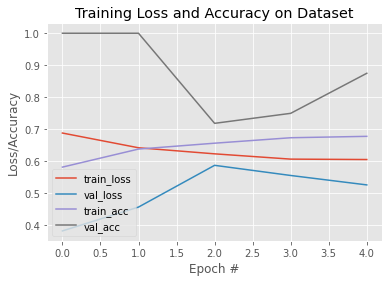

In [29]:
plot_history(history)

# Now let's add dropout and another fully connected layer:

In [ ]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [ ]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
##Callbacks

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor= 'val_acc', verbose=1, save_best_only=True, mode= 'max', save_weights_only = True)
early = EarlyStopping(monitor= 'val_loss', mode= 'min', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

callbacks_list = [checkpoint, early, reduce_lr]

In [ ]:
## Just run a single epoch to see how it does:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 5,
                                   callbacks=callbacks_list )

In [ ]:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

In [ ]:
plot_history(history)

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

    

### Start training! 

In [ ]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
weight_path="{}_my_model.best.hdf5".format('xray_class')
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

In [30]:
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 13ms/step


In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [32]:
acc = accuracy_score(valY, np.round(pred_Y))*100

In [33]:
cm = confusion_matrix(valY, np.round(pred_Y), labels=[0,1])

In [34]:
tn, fp, fn, tp = cm.ravel()

In [35]:
print(cm)

[[ 0  0]
 [ 4 28]]


In [36]:
print('Accuracy: {}%'.format(acc))

Accuracy: 87.5%


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [37]:
print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


TEST METRICS ----------------------
Accuracy: 87.5%
Precision: 100.0%
Recall: 87.5%
F1-score: 93.33333333333333


In [38]:
print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))


TRAIN METRIC ----------------------


KeyError: 'acc'

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)